In [27]:
!pip install transformers

In [28]:

# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
logging.basicConfig(level=logging.ERROR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:

# Load dataset
df_org = pd.read_csv('/content/drive/MyDrive/LLM Research Lab/dataset/dataset-2344.csv')


In [31]:
category_mapping = {
    'TRUE': 0,
    'satire': 1,
    'misleading content': 2,
    'imposter content': 3
}

In [32]:
df_input= pd.DataFrame()
df_input['content'] = df_org['title'] + '\n'  + df_org['content']
df_input['category'] = df_org['category'].map(category_mapping)
df_input.head()

,content,category
0,STOP EVERYTHING! ​Is Will & Grace returning af...,2
1,Florida county commissioner limited vaccine dr...,0
2,"Black Mirror season 6 cast, trailer, release d...",2
3,What's the difference between a Ralph Lauren P...,3
4,David Beckham Joins Queue To Pay Respects To B...,1


   category  count
0         1    753
1         0    661
2         3    538
3         2    392


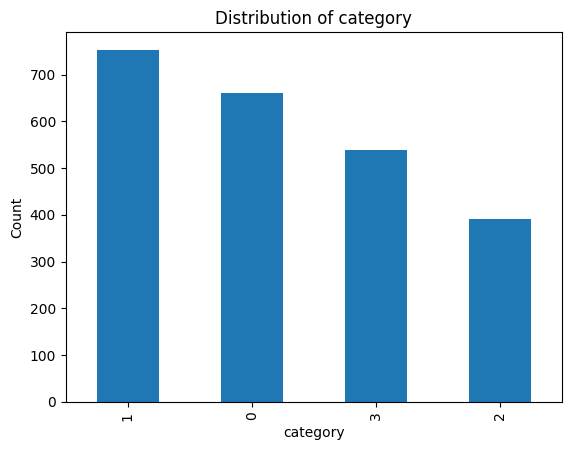

In [33]:
category_column = 'category'


# Show the category-wise distribution
distribution = df_input[category_column].value_counts().reset_index()
distribution.columns = [category_column, 'count']

print(distribution)

# Plot the distribution as a bar chart


distribution.plot(kind='bar', x=category_column, y='count', legend=False)
plt.title(f'Distribution of {category_column}')
plt.xlabel(category_column)
plt.ylabel('Count')
plt.show()

In [34]:

# Define key variables
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)


In [35]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.content
        self.targets = self.data.category
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        if index >= len(self.data):
          raise IndexError("Index out of range")
        text = str(self.text[index])
        text = " ".join(text.split())

        text_inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        text_ids = text_inputs['input_ids']
        text_mask = text_inputs['attention_mask']
        text_token_type_ids = text_inputs["token_type_ids"]



        return {
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [36]:

# Split the dataset
train_data, test_data = train_test_split(df_input, test_size=0.2, stratify=df_input['category'])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


In [37]:

# Prepare dataloaders
train_dataset = SentimentData(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SentimentData(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)


In [38]:

# Define model training and evaluation functions
def train_model(model, train_loader, epochs):
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss = 0
        for _, data in tqdm(enumerate(train_loader, 0)):
            text_ids = data['text_ids'].to(device, dtype=torch.long)
            text_mask = data['text_mask'].to(device, dtype=torch.long)
            text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            ).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()




In [39]:
def evaluate_model(model, test_loader, test_data):
    # ... (rest of the function remains the same)

    predictions = []
    with torch.no_grad():
        for text_ids, text_mask, text_token_type_ids, _ in test_loader:
            text_ids = text_ids.to(device)
            text_mask = text_mask.to(device)
            text_token_type_ids = text_token_type_ids.to(device)

            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            )  # Remove .squeeze() here

            # Check if outputs is 1D and reshape if necessary
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(0)  # Add a dimension

            big_val, big_idx = torch.max(outputs.data, dim=1)
            predictions.extend(big_idx.cpu().numpy())

    # ... (rest of the function remains the same)

In [40]:

# Define the evaluation function
def evaluate(y_true, y_pred):
    labels = ['TRUE', 'satire', 'misleading content', 'imposter content', 'none']
    mapping = {'TRUE': 1, 'satire': 2, 'misleading content': 3, 'imposter content': 4, 'none': 5}

    def map_func(x):
        return mapping.get(x, 5)

    # y_true = np.vectorize(map_func)(y_true)
    # y_pred = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    unique_labels = set(y_true)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4])
    print('\nConfusion Matrix:')
    print(conf_matrix)


In [41]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)  # Adjusted for combined inputs
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, text_ids, text_mask, text_token_type_ids):
        text_output = self.l1(input_ids=text_ids, attention_mask=text_mask, token_type_ids=text_token_type_ids)


        text_hidden_state = text_output[0]

        pooler = text_hidden_state[:, 0]

        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [42]:

# Initialize model
model = RobertaClass()
model.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [43]:
# Train and evaluate
train_model(model, train_loader, EPOCHS)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
469it [01:02,  7.49it/s]


In [44]:
test_data_with_predictions = evaluate_model(model, test_loader, test_data)
test_data_with_predictions.head()

AttributeError: 'str' object has no attribute 'to'

In [ ]:
test_data_with_predictions.to_csv('test_data_with_predictions.csv', index=False)
test_data_with_predictions.head()


In [ ]:
# Evaluate the results
evaluate(test_data_with_predictions['category'], test_data_with_predictions['predicted_category'])